# **IMPORT LIBRARY**

In [40]:
import cv2
import numpy as np
import skimage
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from google.colab.patches import cv2_imshow

# **IMPORT IMAGE**

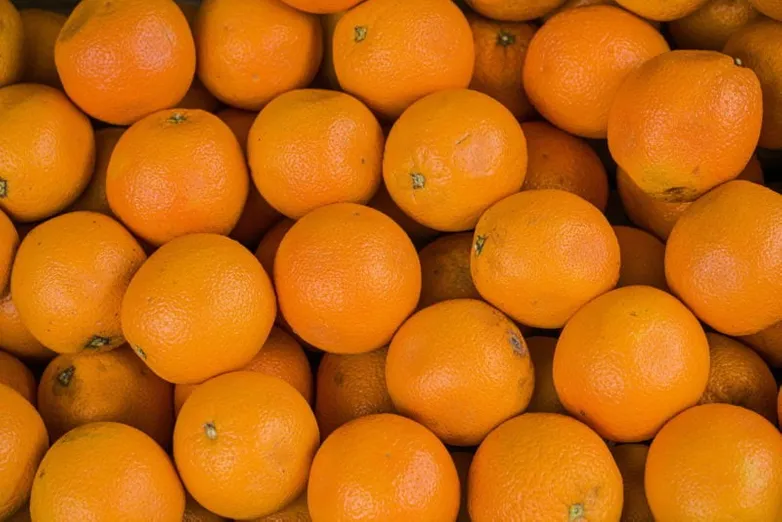

In [41]:
img = cv2.imread('orange.jpg')
cv2_imshow(img)

# **CONVERT IMAGE TO GRAY**

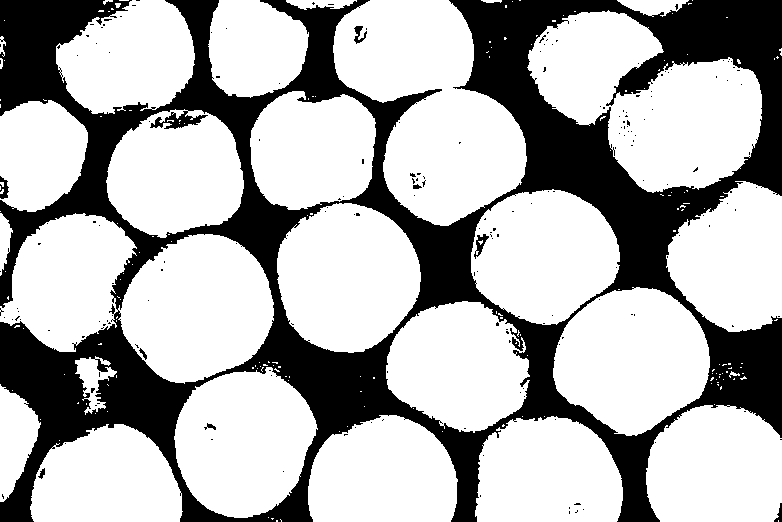

In [42]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh_img = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
cv2_imshow(thresh_img)

# **NOISE REMOVAL**

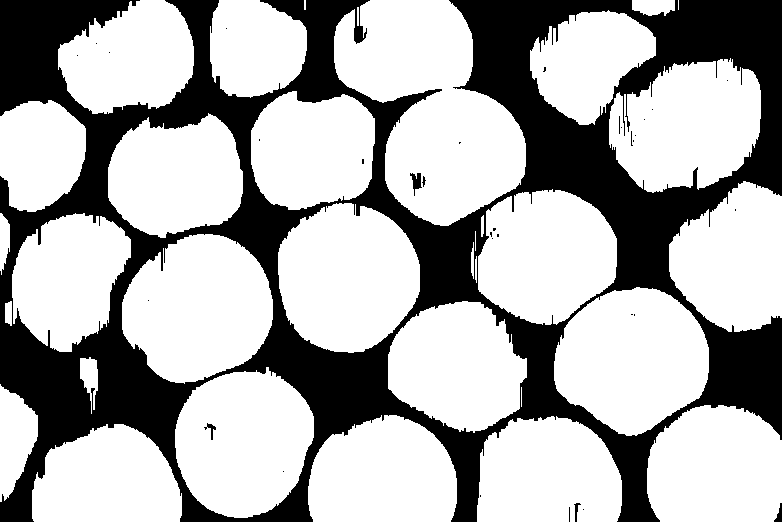

In [43]:
kernel = np.ones((3),np.uint8)
opening_img = cv2.morphologyEx(thresh_img,cv2.MORPH_OPEN, kernel, iterations = 9)

cv2_imshow(opening_img)

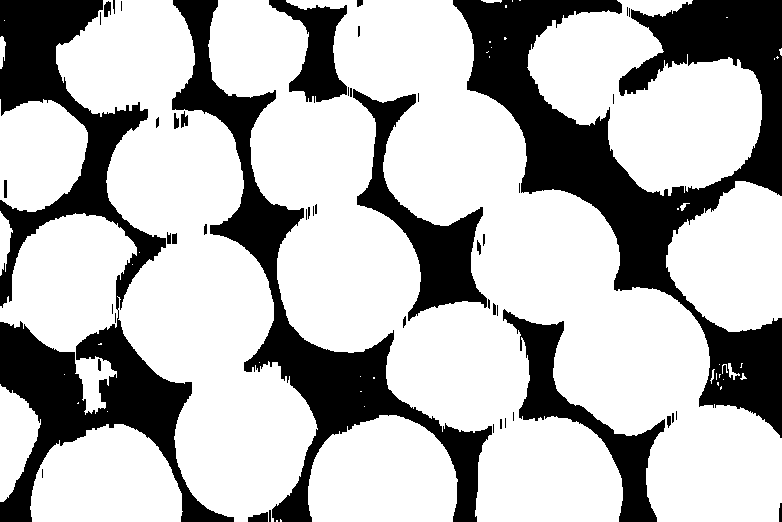

In [44]:
closing_img = cv2.morphologyEx(thresh_img,cv2.MORPH_CLOSE, kernel, iterations = 4)

cv2_imshow(closing_img)

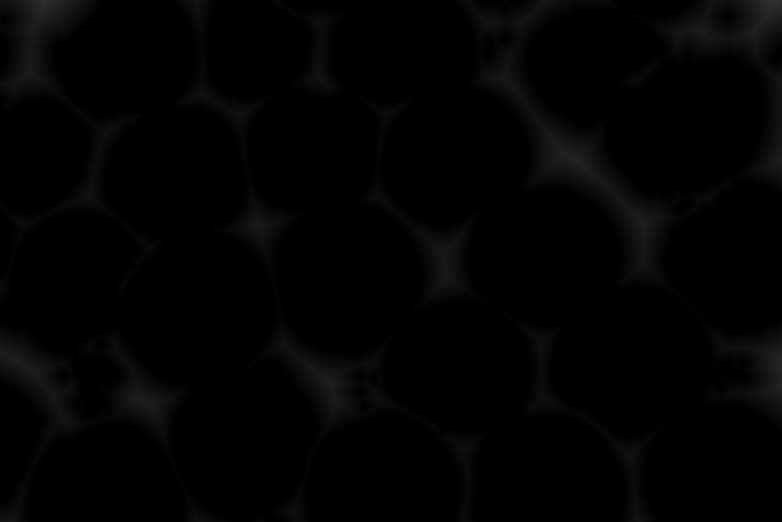

In [45]:
dist_transform = cv2.distanceTransform(255 - closing_img, cv2.DIST_L2, 3)
cv2_imshow(dist_transform)

# **EXTRACT THE COORDINATES OF THE LOCAL MAXIMUM**

In [46]:
local_max_location = peak_local_max(dist_transform, min_distance=1, indices=True)

# **LABELING THE MARKERS WITH K-MEANS**

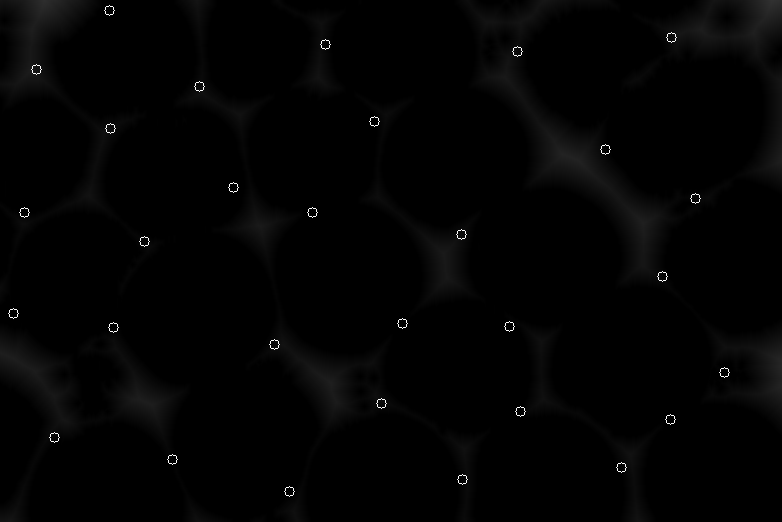

In [47]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=30)
kmeans.fit(local_max_location)
local_max_location = kmeans.cluster_centers_.copy()

# Kmeans is returning a float data type so we need to convert it to an int. 
local_max_location = local_max_location.astype(int)

local_max_location.shape
dist_transform_copy = dist_transform.copy()
for i in range(local_max_location.shape[0]):
  cv2.circle( dist_transform_copy, (local_max_location[i][1],local_max_location[i][0]  ), 5, 255 )

cv2_imshow(dist_transform_copy)

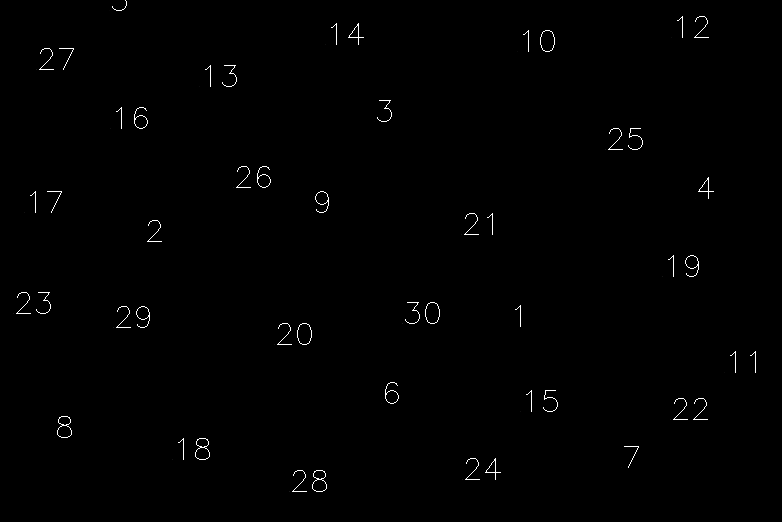

In [48]:
markers = np.zeros_like(dist_transform)
labels = np.arange(kmeans.n_clusters)
markers[local_max_location[:,0],local_max_location[:,1]   ] = labels + 1

# Convert all local markers to an integer. This because cluster centers will be float numbers. 
markers = markers.astype(int)

markers_copy = markers.copy()
index_non_zero_markers = np.argwhere(markers != 0)

markers_copy = markers_copy.astype(np.uint8)

index_non_zero_markers
font = cv2.FONT_HERSHEY_SIMPLEX
for i in range(index_non_zero_markers.shape[0]):
  string_text = str(markers[index_non_zero_markers[i][0] ,index_non_zero_markers[i][1]    ])
  cv2.putText( markers_copy, string_text, (index_non_zero_markers[i][1], index_non_zero_markers[i][0]), font, 1, 255)

cv2_imshow(markers_copy)

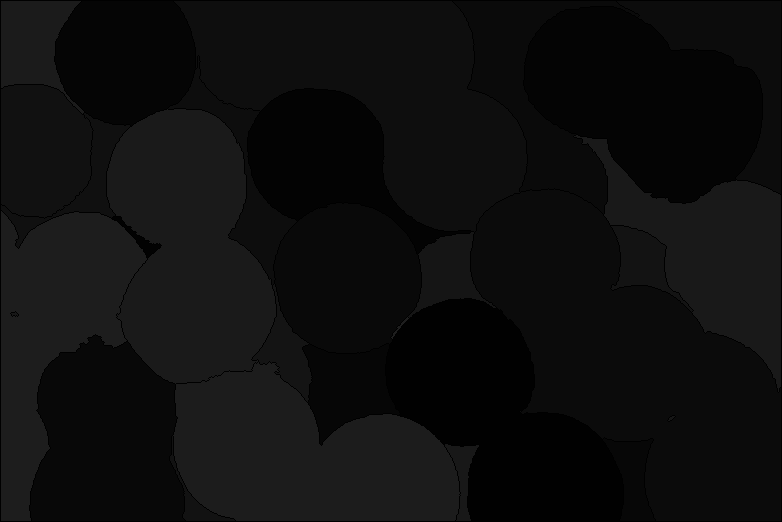

[[-1 -1 -1 ... -1 -1 -1]
 [-1 27 27 ... 12 12 -1]
 [-1 27 27 ... 12 12 -1]
 ...
 [-1 29 29 ... 11 11 -1]
 [-1 29 29 ... 11 11 -1]
 [-1 -1 -1 ... -1 -1 -1]]


In [49]:
markers = markers.astype(np.int32)
segmented = cv2.watershed(img, markers)
cv2_imshow(segmented)
print(segmented)

# **FINAL STEP**

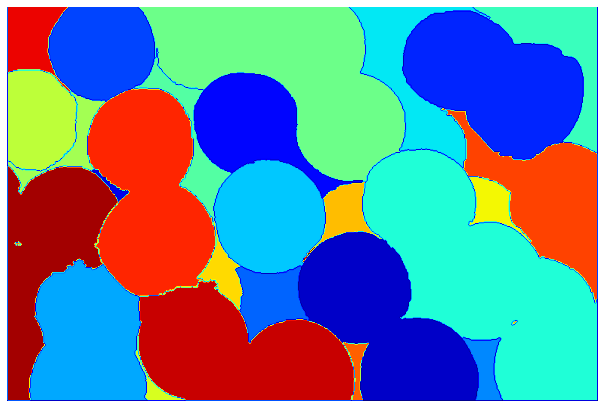

In [50]:
dpi = plt.rcParams['figure.dpi']
figsize = img.shape[1] / float(dpi), img.shape[0] / float(dpi)

plt.figure(figsize=figsize)
plt.imshow(segmented, cmap="jet")
filename = "markers.jpg"
plt.axis('off')
plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)

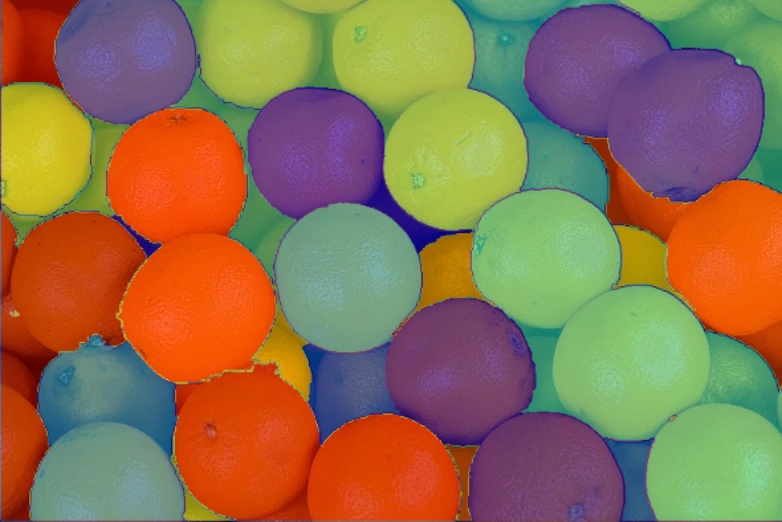

In [51]:
from PIL import Image

overlay = cv2.imread("markers.jpg")
overlay = np.asarray(overlay)

img_copy = img.copy()
overlay_copy = overlay.copy()

overlay_copy = cv2.resize(overlay_copy, (img_copy.shape[1], img_copy.shape[0]))
final_img = cv2.addWeighted(overlay_copy, 0.5, img_copy, 0.5,	0)

cv2_imshow(final_img)

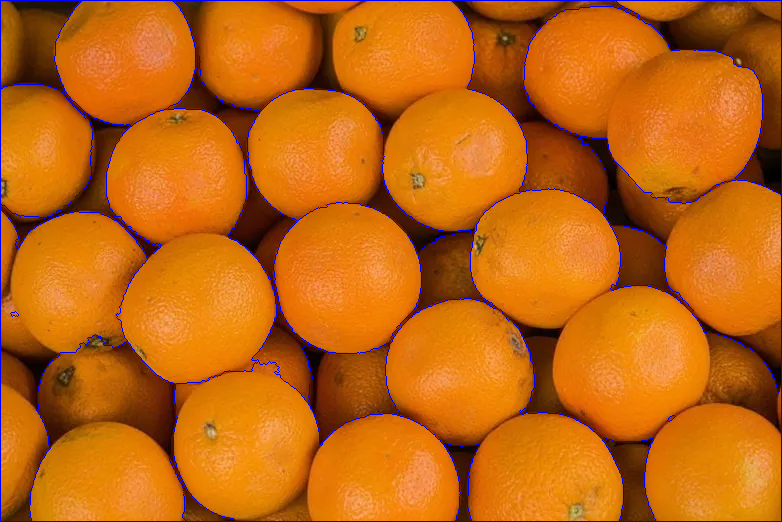

In [52]:
img_c = img.copy() 
img_c[segmented == -1] = [255, 0, 0]
cv2_imshow(img_c)